**Preparación: Descargando el conjunto de datos del Titanic**

El objetivo de este notebook es desarrollar un modelo que prediga quién sobrevivirá en el desastre del Titanic. Para hacer esto, empezaremos descargando el conjunto de datos del Titanic utilizando la API de Kaggle.

1. **Instalación de la API de Kaggle**:

    Primero, necesitamos instalar la biblioteca de la API de Kaggle. Esta biblioteca nos permitirá interactuar con Kaggle y descargar conjuntos de datos directamente en este notebook.

    Instala la biblioteca ejecutando la siguiente celda:
    ```python
    !pip install kaggle
    ```

    Puedes encontrar más detalles sobre cómo utilizar la API de Kaggle en su [documentación oficial](https://www.kaggle.com/docs/api).

2. **Descarga del conjunto de datos**:

    Con la biblioteca instalada, podemos proceder a descargar el conjunto de datos del Titanic. Ejecuta el siguiente comando en una celda:

    ```python
    !kaggle competitions download -c titanic
    ```

    Si deseas explorar más sobre este conjunto de datos, visita la [página de la competencia del Titanic en Kaggle](https://www.kaggle.com/competitions/titanic/data).


In [1]:
!pip install kaggle -q  #-q para no mostrar la salida

In [2]:
!mkdir /root/.kaggle/

Descargamos el [kaggle.json](https://www.kaggle.com/settings)

In [3]:
!mv kaggle.json /root/.kaggle/

In [4]:
#Nos recomienda poner permisos de Lectura y Escritura al archivo .json para el propietario por seguridad.
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
#Nos descargará un .zip
!kaggle competitions download -c titanic

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 42.0MB/s]


In [6]:
#creamos una carpeta y descomprimimos dentro los archivos
!mkdir titanic
!unzip titanic.zip -d ./titanic

Archive:  titanic.zip
  inflating: ./titanic/gender_submission.csv  
  inflating: ./titanic/test.csv      
  inflating: ./titanic/train.csv     


In [7]:
#Listamos los archivos descomprimidos.
!ls ./titanic

gender_submission.csv  test.csv  train.csv


En esta sección, utilizaremos herramientas como Pandas y NumPy para trabajar con nuestros datos.

In [22]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np
ds = pd.read_csv("./titanic/train.csv")

In [9]:
ds.shape   #Vemos que estamos manejando una cantidad muy pequena de datos, 418 filas y 11 columnas.

(891, 12)

In [11]:
ds.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


Al observar los datos, vemos que tenemos un "PassengerID". Aunque estos datos pueden asignarse sin relación alguna con las variables predictivas, prestaremos atención a su poder predictivo. Sin embargo, partimos de la idea de descartarlo, ya que en su mayoría, los ID no representan ningún valor predictivo, a menos que contengan información implícita, como una correlación del número de ID a la clase. Como no contamos con esa información, asumiremos que no tiene información implícita y, por lo tanto, lo consideraremos como una variable con poco poder de predicción.

La "Pclass" nos indica la clase en la que se viaja, siendo 1 la más alta o de mayor poder adquisitivo, y 3 la más económica.

Tenemos los "Nombres". A primera vista, podemos considerarlos como variables categóricas y pensar en alguna forma de representarlos. Realizar una codificación one-hot (OHE) no es recomendable, pero quizá sí segmentar por género. Sin embargo, como ese dato ya está indicado en otra variable y algunos nombres tienen un título como "Mr.", podría ser útil segmentar los nombres según quién contiene ese título y quién no.

"sibsp": Número de hermanos/cónyuges a bordo del Titanic.

"Parch": Número de padres/hijos a bordo del Titanic.

"Ticket": Número de ticket.

"Fare": Tarifa del pasajero, es decir, lo que pagó por el boleto.

"Cabin": Número de cabina. Puede indicarnos en qué parte del barco se encontraban.

"Embarked": Puerto de embarque. C = Cherburgo, Q = Queenstown, S = Southampton. Representa el lugar donde el pasajero subió al barco. Podríamos pensar en el tiempo en el barco puede ser un factor de predicción.

## Aleatorización de Datos

Antes de comenzar el proceso de entrenamiento, es esencial **aleatorizar** o hacer un *shuffle* de nuestros datos.

### ¿Por qué es crucial aleatorizar los datos?

Cuando los datos están ordenados y no se mezclan adecuadamente, pueden surgir problemas al dividirlos para entrenamiento y validación. Imagina una situación en la que todos los ejemplos de una clase particular terminan en el conjunto de validación mientras que otra clase se concentra en el conjunto de entrenamiento. Esto contradice el principio de que nuestra división debería ser una muestra o división aleatoria.

Más información sobre la importancia de barajear los datos puede ser encontrada en esta [discusión de Data Science Stack Exchange](https://datascience.stackexchange.com/questions/24511/why-should-the-data-be-shuffled-for-machine-learning-tasks).

### Evitando la Fuga de Datos

Es fundamental dividir los datos antes de hacer cualquier transformación. Esta precaución nos ayuda a prevenir el **Data Leak**, un problema en el que la información del conjunto de prueba "se filtra" en el proceso de entrenamiento.

Puedes aprender más sobre cómo evitar la fuga de datos en este [artículo de Towards Data Science](https://towardsdatascience.com/avoid-data-leakage-split-your-data-before-processing-a7f172632b00).


In [12]:
ds.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [23]:
shuffled_df = ds.sample(frac=1).reset_index(drop=True)

In [24]:
shuffled_df.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,357,1,1,"Bowerman, Miss. Elsie Edith",female,22.0,0,1,113505,55.0,E33,S


Dividiendo los datos en Train, Validation  and Test.
Train es para ajustar los pesos y Validation para ir viendo el desempeno del modelo, sesgo, varianza, asi como para evitar sobreajuste, ajustar hiperparametros.

Test solo se ocupan una vez para la prueba final, simulando el proceso en produccion.

El conjunto test normalmente se ocupa una vez para una verificacion final, si algo sale mal en esto debes encontrar las causa, pero una principal es que el modelo se sobre-ajusto a los datos de entrenamieno y test, por reajustar iteradamente.

https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7

In [ ]:
# from sklearn.model_selection import train_test_split
# X_train, X_test = train_test_split(shuffled_df, test_size=0.2, random_state=42)

In [25]:
def train_val(df:pd.DataFrame , f:float=0.2)->tuple([pd.DataFrame,pd.DataFrame]):
  test = df.sample(frac = f ,replace = False )
  train =   df[~df.index.isin(test.index)]
  return (train, test)
data_train, data_test = train_val(shuffled_df)

In [57]:
data_train.Survived.value_counts()

0    443
1    270
Name: Survived, dtype: int64

(array([443.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 270.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

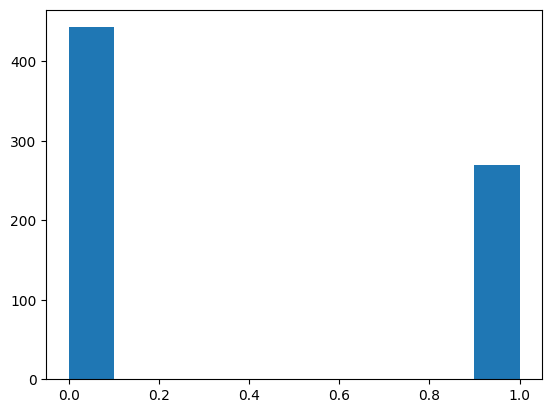

In [51]:
import matplotlib.pyplot as plt
plt.hist(data_train.Survived)

Dado que los modelos usados en tensorflow tienen integrada la opcion de Validacion cruzada, no crearemos esa division de datos hasta ese momento.

Empezaremos con la fase de Limpieza de datos.

Usaremos una metodologia que consiste en revisar columna a columna una lista de limpieza comun a los datos.


* 1  : Repetibilidad en los datos. Existen Datos Repetidos.
* 2  : Inexistencia de datos. Hay datos faltantes, ¿Cómo se tratan?
* 3  : Error en los datos. Hay datos que no sean coherentes con los demás
* 4  : Errores de formato. ‘Espacios en blanco’ error en tipos de datos como char e int, formato de fechas,
* 5  :Verificar formato de fechas
* 6  :Verificar N/a
* 7  :Verificar espacios en blanco
* 8  :Verificar puntos decimal
* 9  :Verificar texto en formato número
* 10 :Verificar misma shape
* 11 :Verificar ortografía
* 12 :Verificar duplicados
* 13 :Verificar rango de datos
* 14 :Verificar números no estén en formato porcentaje o otro
* 15 :Verificar conversiones pesos dólares etc
* 16 :Verificar nombres no sean iguales en duplicados ej: mexico=mex=méxico
* 17 :Verificar en fechas horario de verano, invierno.




Dado que las mismas transformaciones las haremos al conjunto de test, el enfoque sera crear en funciones las transformaciones.

In [ ]:
def duplicados(df):
  return df.drop_duplicates()
data_train = duplicados(data_train)
data_test = duplicados(data_test)

In [ ]:
# Vemos en que columnas hay valores nulos.
for columna in data_train.columns:
    data_na = data_train[columna].isna()
    if data_na.any():
        print(columna, data_na.sum())

Age 139
Cabin 546
Embarked 2


In [ ]:
def passenger_class(ds):
    ds['ID'] = (ds["PassengerId"] - ds["PassengerId"].min()) / (ds["PassengerId"].max() - ds["PassengerId"].min())
    ds['CLASS'] = ds["Pclass"]
    return ds

In [ ]:
data_train = passenger_class(data_train)
data_train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,ID,CLASS
0,612,0,3,"Jardin, Mr. Jose Neto",male,NaN,0,0,SOTON/O.Q. 3101305,7.0500,NaN,S,0.686517,3
1,528,0,1,"Farthing, Mr. John",male,NaN,0,0,PC 17483,221.7792,C95,S,0.592135,1


In [ ]:
def categorize_name(name):
    name_lower = name.lower()  # Convertimos el nombre a minúsculas
    if 'mr' in name_lower:  # Añadido el punto para ser más preciso
        return 'BUCKET_MR'
    elif 'miss' in name_lower:  # Añadido el punto para ser más preciso
        return 'BUCKET_MISS'
    elif 'mrs' in name_lower:  # Añadido el título "Mrs." con el punto para ser más preciso
        return 'BUCKET_MRS'
    else:
        return 'BUCKET_NONE'

data_train['BUCKET'] = data_train['Name'].apply(categorize_name)

# Aplicar One-Hot Encoding usando pandas con drop_first
ohe_columns = pd.get_dummies(data_train['BUCKET'], prefix='OHE', drop_first=True)
data_train = pd.concat([data_train, ohe_columns], axis=1)

In [ ]:
data_train = data_train.drop(columns="BUCKET")

In [ ]:
dummies = pd.get_dummies(data_train["Sex"], prefix="OHE",drop_first=True)
data_train = pd.concat([data_train, dummies], axis=1)

In [ ]:
def S_P_T(ds):
  ds["SIBSP"] = ds["SibSp"]
  ds["PARCH"] = ds["Parch"]
  # ds['TICKET'] = (ds["Ticket"] - ds["Ticket"].min()) / (ds["Ticket"].max() - ds["Ticket"].min())
  return ds
data_train = S_P_T(data_train)
#Omitiremos ticket por la misma razon de PassengerId, solo que dedidimos dejar PassengerId para mostrar su poder predictivo

In [ ]:
data_train.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,ID,CLASS,OHE_BUCKET_MR,OHE_BUCKET_NONE,OHE_male,SIBSP,PARCH
0,760,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0,0,110152,86.5,B77,S,0.852809,1,0,1,0,0,0


Para los valores desconocidos de Age, pondremos un -1 que simulara un valor desconocido.

In [ ]:
data_train['AGE'] = data_train['Age'].fillna(-1)

In [ ]:
#Dado que solo tenemos un valor nulo en Fare, usaremos el promedio que se paga en esa clase para rellenarlo
data_train[data_train["Fare"].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,ID,CLASS,OHE_BUCKET_MR,OHE_BUCKET_NONE,OHE_male,SIBSP,PARCH,AGE


In [ ]:
fare_mean = data_train.loc[data_train["Pclass"] == 3,["Fare"]].mean()
data_train['FARE'] = data_train['Fare'].fillna(fare_mean[0])
data_train['Cabin'].fillna('Desconocido', inplace=True)

In [ ]:
# Convertir la columna 'Cabin' a categorías y luego a códigos numéricos
data_train['CABIN'] = data_train['Cabin'].astype('category').cat.codes

In [ ]:
EMBARKED = pd.get_dummies(data_train["Embarked"],prefix="OHE",drop_first=True)
data_train = pd.concat([data_train,  EMBARKED], axis=1)

In [ ]:
data_train["SURVIVED"] = data_train["Survived"]

In [26]:
class data_set_preparation():
  def __init__(self):
    print("Inicio")
  def __call__(self,ds):
    data_train = self.duplicados(ds)
    data_train = self.passenger_class(data_train)
    data_train = self.preprocess_data(data_train)
    data_train = data_train.drop(columns="BUCKET")
    data_train = self.data_sex(data_train)
    data_train = self.S_P_T(data_train)
    data_train = self.fill_na_fare_based_on_pclass(data_train)
    data_train = self.cab(data_train)
    return data_train

  def duplicados(self,df):
    return df.drop_duplicates()
  def passenger_class(self,ds):
    ds["PassengerId"] = ds["PassengerId"].fillna(0)
    ds['ID'] = (ds["PassengerId"] - ds["PassengerId"].min()) / (ds["PassengerId"].max() - ds["PassengerId"].min())
    ds["Pclass"] = ds["Pclass"].fillna("Desconocido")
    ds['CLASS'] = ds["Pclass"]
    return ds

  @staticmethod
  def categorize_name(name):
      name_lower = name.lower()
      if 'mr' in name_lower:
          return 'BUCKET_MR'
      elif 'miss' in name_lower:
          return 'BUCKET_MISS'
      elif 'mrs' in name_lower:
          return 'BUCKET_MRS'
      else:
          return 'BUCKET_NONE'
  def preprocess_data(self, df):
      df['BUCKET'] = df['Name'].apply(self.categorize_name)
      # Aplicar One-Hot Encoding usando pandas con drop_first
      ohe_columns = pd.get_dummies(df['BUCKET'], prefix='OHE', drop_first=True)
      df = pd.concat([df, ohe_columns], axis=1)
      return df
  def data_sex(self,ds):
      ds["Sex"] = ds["Sex"].fillna("Desconocido")
      dummies = pd.get_dummies(ds["Sex"], prefix="OHE",drop_first=True)
      ds = pd.concat([ds, dummies], axis=1)
      return ds
  def S_P_T(self,ds):
    ds["SIBSP"] = ds["SibSp"].fillna(0)
    ds["PARCH"] = ds["Parch"].fillna(0)
    ds['AGE'] = ds['Age'].fillna(-1)
    return ds

  def fill_na_fare_based_on_pclass(self,df):
      # Obtener las clases únicas
      unique_classes = df["Pclass"].dropna().unique()
      # Iterar por cada clase
      for pclass in unique_classes:
          class_mean = df.loc[df["Pclass"] == pclass, "Fare"].mean()
          # Establecer una condición para identificar los valores NaN en 'Fare' para una Pclass específica
          condition = (df["Pclass"] == pclass) & (df["Fare"].isna())
          # Rellenar los NaN basados en la condición
          df.loc[condition, "Fare"] = class_mean
      return df
  def cab(self,ds):
    ds['Cabin'] = ds['Cabin'].fillna("unknown")
    # Convertir la columna 'Cabin' a categorías y luego a códigos numéricos
    ds['CABIN'] = ds['Cabin'].astype('category').cat.codes
    ds['Embarked'] = ds['Embarked'].fillna("unknown")
    EMBARKED = pd.get_dummies(ds["Embarked"],prefix="OHE",drop_first=True)
    ds = pd.concat([ds,  EMBARKED], axis=1)
    return ds

In [27]:
clean = data_set_preparation()

Inicio


In [28]:
d_train = clean(data_train)
d_test  = clean(data_test)

In [29]:
#agregamos columna para coincidencia.
d_test["OHE_unknown"]=0

In [30]:
d_test.shape,d_train.shape

((178, 24), (713, 24))

In [31]:
x_train,y_train = d_train.iloc[:,12:].to_numpy() , d_train.iloc[:,1].to_numpy()
x_test,y_test = d_test.iloc[:,12:].to_numpy() , d_test.iloc[:,1].to_numpy()

In [32]:
x_train.shape , y_train.shape, x_test.shape,y_test.shape

((713, 12), (713,), (178, 12), (178,))

Empezamos a buscar el mejor modelo

In [33]:
from sklearn.linear_model import LogisticRegression

# Inicializar y entrenar el modelo
logistic_model = LogisticRegression(max_iter=10000)
logistic_model.fit(x_train, y_train)

# Hacer predicciones en el conjunto de test
y_pred_logistic = logistic_model.predict(x_test)


In [34]:
from sklearn.tree import DecisionTreeClassifier

# Inicializar y entrenar el modelo
tree_model = DecisionTreeClassifier()
tree_model.fit(x_train, y_train)

# Hacer predicciones en el conjunto de test
y_pred_tree = tree_model.predict(x_test)


In [35]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Construir el modelo
neural_model = Sequential()
neural_model.add(Dense(14, activation='elu', input_dim=x_train.shape[1]))
neural_model.add(Dense(18, activation='gelu'))
neural_model.add(Dense(7, activation='gelu'))
neural_model.add(Dense(19, activation='relu'))
neural_model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
neural_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
neural_model.fit(x_train, y_train, epochs=100, batch_size=16, validation_data=(x_test, y_test))

# Hacer predicciones en el conjunto de test
y_pred_neural = (neural_model.predict(x_test) > 0.5).astype("int32")


Epoch 1/100
45/45 [==============================] - 2s 8ms/step - loss: 0.7229 - accuracy: 0.5849 - val_loss: 0.7887 - val_accuracy: 0.5000
Epoch 2/100
45/45 [==============================] - 0s 3ms/step - loss: 0.6526 - accuracy: 0.6396 - val_loss: 0.7263 - val_accuracy: 0.5337
Epoch 3/100
45/45 [==============================] - 0s 3ms/step - loss: 0.6464 - accuracy: 0.6396 - val_loss: 0.7368 - val_accuracy: 0.5169
Epoch 4/100
45/45 [==============================] - 0s 3ms/step - loss: 0.6465 - accuracy: 0.6438 - val_loss: 0.7238 - val_accuracy: 0.5281
Epoch 5/100
45/45 [==============================] - 0s 3ms/step - loss: 0.6433 - accuracy: 0.6424 - val_loss: 0.7686 - val_accuracy: 0.5112
Epoch 6/100
45/45 [==============================] - 0s 3ms/step - loss: 0.6430 - accuracy: 0.6424 - val_loss: 0.7282 - val_accuracy: 0.5506
Epoch 7/100
45/45 [==============================] - 0s 3ms/step - loss: 0.6416 - accuracy: 0.6466 - val_loss: 0.7167 - val_accuracy: 0.5393
Epoch 8/100
4

In [36]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Definir el modelo base (un árbol de decisión)
base_model = DecisionTreeClassifier(max_depth=1)

# Crear el modelo AdaBoost
ada_model = AdaBoostClassifier(base_estimator=base_model, n_estimators=150)

# Entrenar el modelo
ada_model.fit(x_train, y_train)

# Hacer predicciones
y_pred_adaboost = ada_model.predict(x_test)


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [37]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Precisión
precision_logistic = precision_score(y_test, y_pred_logistic)
precision_tree = precision_score(y_test, y_pred_tree)
precision_neural = precision_score(y_test, y_pred_neural)
precision_adaboost = precision_score(y_test, y_pred_adaboost)

# Recall
recall_logistic = recall_score(y_test, y_pred_logistic)
recall_tree = recall_score(y_test, y_pred_tree)
recall_neural = recall_score(y_test, y_pred_neural)
recall_adaboost = recall_score(y_test, y_pred_adaboost)

# F1-Score
f1_logistic = f1_score(y_test, y_pred_logistic)
f1_tree = f1_score(y_test, y_pred_tree)
f1_neural = f1_score(y_test, y_pred_neural)
f1_adaboost = f1_score(y_test, y_pred_adaboost)

print("Precision de la Regresión Logística:", precision_logistic)
print("Recall de la Regresión Logística:", recall_logistic)
print("F1-score de la Regresión Logística:", f1_logistic)
print("\n")
print("Precision del Árbol de Decisión:", precision_tree)
print("Recall del Árbol de Decisión:", recall_tree)
print("F1-score del Árbol de Decisión:", f1_tree)
print("\n")
print("Precision de la Red Neuronal:", precision_neural)
print("Recall de la Red Neuronal:", recall_neural)
print("F1-score de la Red Neuronal:", f1_neural)
print("\n")
print("Precision de AdaBoost:", precision_adaboost)
print("Recall de AdaBoost:", recall_adaboost)
print("F1-score de AdaBoost:", f1_adaboost)


Precision de la Regresión Logística: 0.7857142857142857
Recall de la Regresión Logística: 0.7638888888888888
F1-score de la Regresión Logística: 0.7746478873239437


Precision del Árbol de Decisión: 0.6835443037974683
Recall del Árbol de Decisión: 0.75
F1-score del Árbol de Decisión: 0.7152317880794701


Precision de la Red Neuronal: 0.684931506849315
Recall de la Red Neuronal: 0.6944444444444444
F1-score de la Red Neuronal: 0.6896551724137931


Precision de AdaBoost: 0.6626506024096386
Recall de AdaBoost: 0.7638888888888888
F1-score de AdaBoost: 0.7096774193548386


In [38]:
# Obten las probabilidades predichas para la clase
#x_train, y_train
y_probs_logistic = logistic_model.predict_proba(x_train)[:, 1]

thresholds = np.linspace(0, 1, 20)  # 20 umbrales desde 0 hasta 1
best_threshold = 0
best_difference = float('inf')  # inicializamos con un valor muy alto

for threshold in thresholds:
    y_pred_threshold = (y_probs_logistic > threshold).astype(int)  # Convertir probabilidades en 1 o 0 basado en el umbral
    precision = precision_score(y_train, y_pred_threshold)
    recall = recall_score(y_train, y_pred_threshold)

    # Aquí simplemente estoy tomando el umbral donde la diferencia entre precision y recall es mínima
    # Puedes usar otros criterios según tus necesidades
    difference = abs(precision - recall)
    if difference < best_difference:
        best_difference = difference
        best_threshold = threshold

    print(f"Umbral: {threshold:.2f} | Precisión: {precision:.2f} | Recall: {recall:.2f}")

print(f"Mejor umbral basado en la mínima diferencia entre precisión y recall: {best_threshold:.2f}")


Umbral: 0.00 | Precisión: 0.38 | Recall: 1.00
Umbral: 0.05 | Precisión: 0.39 | Recall: 1.00
Umbral: 0.11 | Precisión: 0.47 | Recall: 0.92
Umbral: 0.16 | Precisión: 0.56 | Recall: 0.89
Umbral: 0.21 | Precisión: 0.62 | Recall: 0.88
Umbral: 0.26 | Precisión: 0.64 | Recall: 0.87
Umbral: 0.32 | Precisión: 0.66 | Recall: 0.81
Umbral: 0.37 | Precisión: 0.68 | Recall: 0.77
Umbral: 0.42 | Precisión: 0.71 | Recall: 0.74
Umbral: 0.47 | Precisión: 0.74 | Recall: 0.72
Umbral: 0.53 | Precisión: 0.78 | Recall: 0.68
Umbral: 0.58 | Precisión: 0.81 | Recall: 0.65
Umbral: 0.63 | Precisión: 0.85 | Recall: 0.60
Umbral: 0.68 | Precisión: 0.88 | Recall: 0.54
Umbral: 0.74 | Precisión: 0.93 | Recall: 0.44
Umbral: 0.79 | Precisión: 0.95 | Recall: 0.34
Umbral: 0.84 | Precisión: 0.95 | Recall: 0.27
Umbral: 0.89 | Precisión: 0.98 | Recall: 0.18
Umbral: 0.95 | Precisión: 1.00 | Recall: 0.01
Umbral: 1.00 | Precisión: 0.00 | Recall: 0.00
Mejor umbral basado en la mínima diferencia entre precisión y recall: 1.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


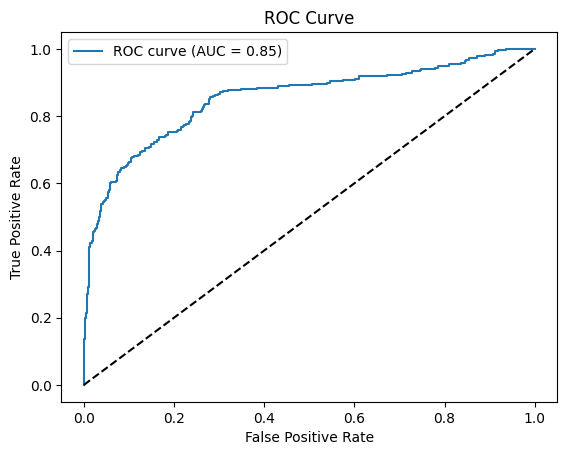

In [39]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_probs_logistic = logistic_model.predict_proba(x_train)[:, 1]
fpr, tpr, thresholds = roc_curve(y_train, y_probs_logistic)

plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc_score(y_train, y_probs_logistic))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()


In [40]:
ds_send = pd.read_csv("./titanic/test.csv")
ds_send.head(1)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q


In [41]:
d_t_clean = clean(ds_send)
d_t_clean["OHE_unknown"] = 0
data_pred = d_t_clean.iloc[:,np.r_[0, 11:d_t_clean.shape[1]]]# Seleccionamos desde el 11 ya que no tenemos la columna Suvivor

Dado que el modelo logistico fue el que tuvo mayor

In [42]:
data_pred.head(1)

,PassengerId,ID,CLASS,OHE_BUCKET_MR,OHE_BUCKET_NONE,OHE_male,SIBSP,PARCH,AGE,CABIN,OHE_Q,OHE_S,OHE_unknown
0,892,0.0,3,1,0,1,0,0,34.5,76,1,0,0


In [43]:
y_pred_logistic_test = logistic_model.predict(data_pred.iloc[:,1:].to_numpy())

In [44]:
data_pred['Survived'] = y_pred_logistic_test

<ipython-input-44-6f3b98732bef>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pred['Survived'] = y_pred_logistic_test


In [45]:
data_pred[["PassengerId","Survived"]].to_csv("gender_submission.csv",index=False)
#Obtuvimos un Score: 0.77511
#Intentaremos mejorar esa puntuacion con ingenieria de funciones despues.

Despliegue del modelo, usaremos 2 formas, una es cargar los pesos del modelo y descargarlos remotamente y subirlo a un endpoint.

In [46]:
from joblib import dump, load
dump(logistic_model, 'logistic_model.joblib')

['logistic_model.joblib']

Ahora podemos subir y guardar el modelo en google cloud y acceder a el despues

In [ ]:
#!gsutil mb gs://mi_bucket
#!gsutil cp logistic_model.joblib gs://mi_bucket

In [ ]:
#!gsutil cp gs://mi_bucket/logistic_model.joblib .
#CArga del modelo
#loaded_model = load('logistic_model.joblib')
#predictions = loaded_model.predict(some_new_data)

Desplegar el modelo en un endpoint